In [2]:
# Packages need to be imported

import pandas as pd
import regex as re
import numpy as np
from rapidfuzz import process, fuzz

In [3]:
file_path = '/Users/dheeraj.srivathsav/Downloads/'
df = pd.read_excel(file_path + 'DS Case (1).xlsx', sheet_name = 'Make Model Count Data')

In [4]:
sheets = pd.ExcelFile(file_path + 'DS Case (1).xlsx').sheet_names
print(sheets)

['Case Instructions', 'Make Model Count Data']


## 1. Exploratory Data Analysis

#### Get unique number of makes and model present in the dataset


In [5]:
# Get unique number of makes and model present in the dataset
no_of_unique_makes: int = df['Make'].nunique()
no_of_unique_models: int  = df['Model'].nunique()
print(f"No of Unique Makes: {no_of_unique_makes}, No of Unique Models: {no_of_unique_models}")

No of Unique Makes: 13295, No of Unique Models: 909098


#### Check for missing values


In [6]:
# Check for missing values
missing_make = df['Make'].isnull().sum()
missing_model = df['Model'].isnull().sum()
print(f"Missing Make: {missing_make}, Missing Model: {missing_model}")

Missing Make: 1542, Missing Model: 388


In [7]:
# To know which make or models have null values
df[df['Make'].isnull() == True]
df[df['Model'].isnull() == True]

,Make,Model,Count
3262,AAON,NaN,1
3265,AAON,NaN,13
11967,AAON INC,NaN,1
12742,ABB,NaN,14
13775,ADANDE,NaN,1
...,...,...,...
991176,YORK,NaN,5
991177,YORK,NaN,23
1012988,YORK INTERNATIONAL,NaN,1
1012994,YORK SERVICE,NaN,1


In [8]:
df['Make'].value_counts().head(20)  # Top 20 most common 'Make' values
# df['Model'].value_counts().head(20)  # Top 20 most common 'Model' values

Make
TRANE                    380024
OTHER                    122725
CARRIER                   80370
YORK                      38416
LENNOX                    24279
DAIKIN                    16594
RHEEM                     15861
GOODMAN                   15627
GREENHECK                 14814
INTERNATIONAL COMFORT     12539
AAON                      11515
BRYANT                    10168
LIEBERT                    9214
MCQUAY                     7926
MITSUBISHI                 7711
HEATCRAFT                  7113
LOREN COOK                 6988
BARD                       6377
RANE                       5791
COPELAND                   5392
Name: count, dtype: int64

In [9]:
## Clean the DF
df.loc[:, 'Make'] = df['Make'].str.replace(r'[^a-zA-Z0-9 ]', '', regex=True)
df['Make'] = df['Make'].astype('str')

#### Frequency distribution of top 10 Makes and models


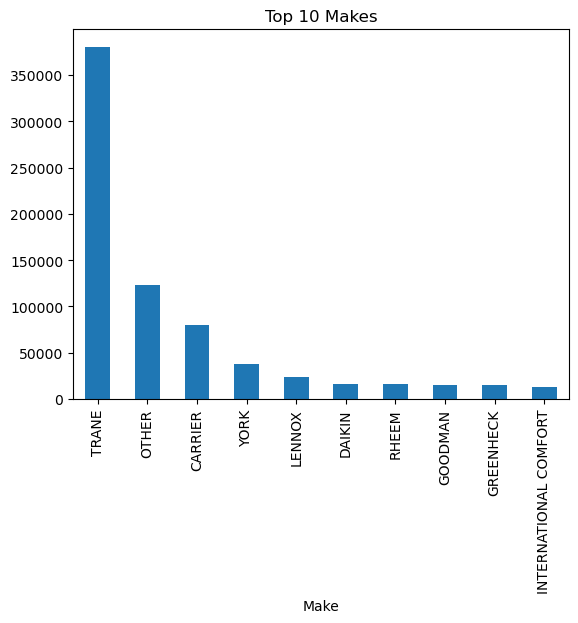

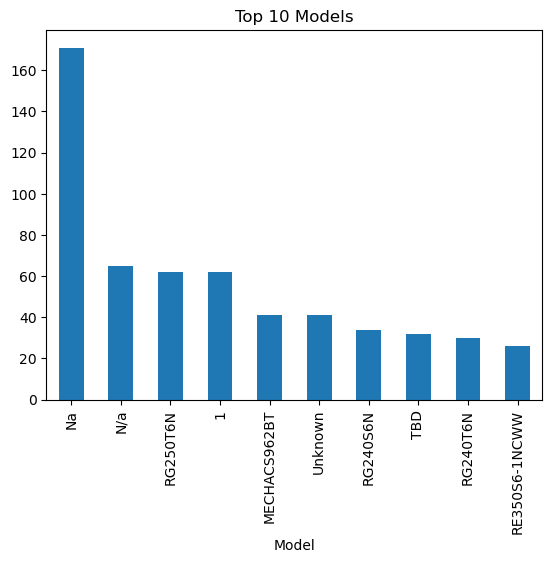

In [10]:
import matplotlib.pyplot as plt

# Frequency distribution of top 10 Makes
top_10_make = df['Make'].value_counts().head(10)
top_10_make.plot(kind='bar', title='Top 10 Makes')
plt.show()

# Frequency distribution of top 10 Models
top_10_model = df['Model'].value_counts().head(10)
top_10_model.plot(kind='bar', title='Top 10 Models')
plt.show()

#### Calculate the string lengths of Make and Model


In [11]:
df['make_length'] = df['Make'].str.len()
df['model_length'] = df['Model'].str.len()

# Identify Make/Model values with unusually short or long strings
short_makes_df = df[df['make_length'] < 3] # Make with 2 chars doesn't see to be legit
long_makes_df = df[df['model_length'] > 20]

In [12]:
# TO see what unique makes have short or long char len
short_makes_df['Make'].unique()
long_makes_df['Make'].unique()

array(['000', '1995', '1HANE', ..., 'YYYYYYYYYY', 'ZERO', ' SMITH'],
      dtype=object)

#### Identify makes and models with only digits

In [13]:
df['only_digit_make'] = df['Make'].str.contains(r'^\d+$', na = False)
only_digit_makes = df[df['only_digit_make'] == True] # 81 makes with only digits
only_digit_makes.shape

df['only_digit_models'] = df['Model'].str.contains(r'^\d+$', na = False)
only_digit_models = df[df['only_digit_models'] == True] # 81 makes with only digits
only_digit_models.shape

print(f"length of only digit makes: {only_digit_makes.shape}, length of only digit makes: {only_digit_models.shape}")

length of only digit makes: (87, 6), length of only digit makes: (6342, 7)


#### Identify makes and models with only special characters


In [14]:
# Identify makes and models with only special characters

df['only_special_chars_make'] = df['Make'].str.contains(r'^[^\w\d\s]+$')
df[df['only_special_chars_make'] == True]

df['only_special_chars_model'] = df['Model'].str.contains(r'^[^\w\d\s]+$')
df[df['only_special_chars_model'] == True]

,Make,Model,Count,make_length,model_length,only_digit_make,only_digit_models,only_special_chars_make,only_special_chars_model
0,,-,4,0,1.0,False,False,False,True
3,,",",1,0,1.0,False,False,False,True
4,,?,11,0,1.0,False,False,False,True
8,,???,1,0,3.0,False,False,False,True
9,,???????,1,0,7.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...
956334,TURBO AIR,****,1,9,4.0,False,False,False,True
960219,UNIT44,?,1,6,1.0,False,False,False,True
960220,UNIT45,?,1,6,1.0,False,False,False,True
961083,UNSURE,?,1,6,1.0,False,False,False,True


### Remove all invalid records

#### Conditions to consider if records are invalid
1. If length of the make or model is < 3 chars. They all seems invalid.
2. If only digits are present in the make - They all seems invalid.
3. If only special characters are present in Make, they are considered invalid
4. If we have null, nans values in Make or Model
5. Model with 'N/a' or '1' are invalid
6. Model Unknown or TBD can also be considerd as invalid

In [15]:
## Remove all unwanted rows with invalid data

invalid_condition = (df['make_length'] < 3) | (df['model_length'] < 3) | (df['only_digit_make'] == True) | (df['only_special_chars_make'] == True) | (df['only_special_chars_model'] == True) | (df['Model'].isnull() == True)| (df['Make'] == 'nan')| (df['Model'] == '1') | (df['Model'] == 'N/a') | (df['Model'] == 'Unknown') | (df['Model'] == 'TBD')  
invalid_df = df[invalid_condition]

df_cleaned = df[~invalid_condition]

df_cleaned.reset_index(drop=True, inplace=True)

print(f"Shape of Invalid df {invalid_df.shape}, Shape of cleaned df {df_cleaned.shape}")

Shape of Invalid df (6749, 9), Shape of cleaned df (1006523, 9)


In [16]:
df_cleaned

,Make,Model,Count,make_length,model_length,only_digit_make,only_digit_models,only_special_chars_make,only_special_chars_model
0,00 IEBERT,VS070AUA1E1046C,1,9,15.0,False,False,False,False
1,00LIEBERT,CW181DC1A1S557,1,9,14.0,False,False,False,False
2,00LIEBERT,CW181DC1A1S911,1,9,14.0,False,False,False,False
3,00LIEBERT,DA150DP1AT909A,1,9,14.0,False,False,False,False
4,00LIEBERT,PFH037A-AH7,1,9,11.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1006518,321034807,Compact800,1,10,10.0,False,False,False,False
1006519,SMITH,ENT-50 110,1,6,10.0,False,False,False,False
1006520,SMITH,GCG-50 400,1,6,10.0,False,False,False,False
1006521,SMITH,GCRL-40 400,1,6,11.0,False,False,False,False


## "Make" column Analysis

In [17]:
# after removing invalid records
unique_makes_after_cleaning = df['Make'].nunique()
unique_makes_after_cleaning

12771

In [18]:
df_cleaned.shape

(1006523, 9)

#### Data Coverage, Dominant Makes


In [19]:
make_counts = df_cleaned['Make'].value_counts().reset_index()

# Rename the columns
make_counts.columns = ['Make', 'count']

min_no_of_records_per_make = 20
dominant_makes_df = make_counts[make_counts['count'] >= min_no_of_records_per_make]
no_of_makes_meeting_threshold = dominant_makes_df.shape[0]
percentage_of_coverage = round(dominant_makes_df['count'].sum()/df_cleaned.shape[0] * 100, 2)

print( f"There are {no_of_makes_meeting_threshold} makes that meet the threshold of minimum {min_no_of_records_per_make} models per make and cover {percentage_of_coverage} % of data. " )

There are 491 makes that meet the threshold of minimum 20 models per make and cover 97.74 % of data. 


#### Analyze possible errors by looking at the rare Makes

In [20]:
rare_makes_df = make_counts[make_counts['count'] <= 1]
rare_makes_df

,Make,count
3849,NOPLATEFOUND,1
3850,NONDECAF,1
3851,NORTH AMERICAN ELECTRIC,1
3852,NOPICTURE,1
3853,NARSCO,1
...,...,...
12208,GRANBY INDUSTRIES,1
12209,GRANEVA,1
12210,GRNO,1
12211,GRANZOW,1


In [21]:
# Go through the rare_df to understands the potential errors
# rare_makes_df['Make'].to_list()[:50]

## 2. Characterize the types of errors we are getting in the Make values and determine the error records

#### Possible Reasons for Makes that are very rare:
    
##### 1. Either it could be a new equipment
##### 2. Technicans rarely work on those type of makes
##### 3. Due to OCR issues there could be serveral error possibilities.

In [22]:
# Some Examples as per the rare_makes_df:
# Makes that are same but due to some OCR or other issues its considered as a NEW make

'PEERELESS','PEERLESSBOILER', 'PEERIESS', 'PEEMESS', 'PEERLESS BOILERS'
'WWW. BRADFORD WHIT', 'WWW.BRADFORDWHIT', 'WWW.BRADFORDWHITE.COM', 'WWWBRADFORDWHITE', 'WWW.BRADFORDWHITE.', '(WWWBRADFORDWHITE'
'MITSUBISHI', 'MITHUBIEHI', 'MITAUBIBHI', 'MITSUBISHI ELECTRIC', 'MITSUBISHI ELECTRIC CORPORATION', 'MIT JUBISHI'
'PENNE3ARRY', 'PENNNBARRY', 'PENNEXINC', 'PENNENBERG', 'PENNEBARY', 'PENNEARY',

('PENNE3ARRY',
 'PENNNBARRY',
 'PENNEXINC',
 'PENNENBERG',
 'PENNEBARY',
 'PENNEARY')

### The errors in "Make" Values typically fall into the following categories:

### OCR Errors:

##### OCR mistakes: A letter is misread, such as "GOOUMAN" instead of "GOODMAN", "L3NNOX" instead of "LENNOX".

### Missing or Extra Characters:

##### Missing characters: Parts of the make are missing, such as "CARRER" instead of "CARRIER".
##### Extra characters: Extra letters or numbers in the name, such as "LENNOXX" instead of "LENNOX".

### Merged Words:

##### Concatenated makes: Some makes may be merged, e.g., "PEERLESSBOILER" instead of "PEERLESS BOILERS".
##### Hyphenated or non-hyphenated issues: Sometimes, brands with compound words are written incorrectly, e.g., "BRYANTDAYNIGHT" instead of "BRYANT DAY & NIGHT".

### Incorrect Use of Special Characters:

##### Extra spaces, special characters: Like 'WWWBRADFORDWHITE', 'WWW.BRADFORDWHITE.', '(WWWBRADFORDWHITE'.
##### No Space: "BRYANTDAY&NIGHT" instead of "BRYANT DAY & NIGHT".

### Duplication

##### Repetition: Same word appearing twice 'TRANE TRANE',

### Abbreviations or Truncations:

##### Shortened forms: Like "TRN" for "TRANE" or "RHM" for "RHEEM".
##### Acronyms: Users may use acronyms for makes/models (e.g., "GDM" for "GOODMAN").


## 3. Determine how we can map erroneous Make values to correct Makes

In [23]:
# Clean the Dataset by removing special characters from Make

In [24]:
# df_cleaned['Make'] = df_cleaned['Make'].apply(lambda x:remove_special_chars(x))

In [25]:
make_counts = df_cleaned['Make'].value_counts().reset_index()

# Rename the columns
make_counts.columns = ['Make', 'count']

min_no_of_records_per_make = 20
dominant_makes_df = make_counts[make_counts['count'] >= min_no_of_records_per_make]
dominant_makes_meeting_threshold = dominant_makes_df.shape[0]
percentage_of_dominant_makes_coverage = round(dominant_makes_df['count'].sum()/df_cleaned.shape[0] * 100, 2)

rare_makes_df = make_counts[make_counts['count'] < min_no_of_records_per_make]
rare_makes_meeting_threshold = rare_makes_df.shape[0]
percentage_of_rare_makes_coverage = round(rare_makes_df['count'].sum()/df_cleaned.shape[0] * 100, 2)

print( f"There are {dominant_makes_meeting_threshold} makes that meet the threshold of minimum {min_no_of_records_per_make} models per make and cover {percentage_of_dominant_makes_coverage} % of data. " )

print( f"There are {rare_makes_meeting_threshold} makes that does not meet the threshold of minimum {min_no_of_records_per_make} models per make and cover {percentage_of_rare_makes_coverage} % of data. " )


There are 491 makes that meet the threshold of minimum 20 models per make and cover 97.74 % of data. 
There are 11722 makes that does not meet the threshold of minimum 20 models per make and cover 2.26 % of data. 


### Correcting the dominant_makes

In [26]:
# Picked makes that have atleast 70 models - and treat it as the correct_makes
correct_makes = dominant_makes_df[dominant_makes_df['count'] > 70]['Make'].to_list()
# correct_makes
temp_df = dominant_makes_df[dominant_makes_df['count'] > 70]
correct_makes_dict = dict(zip(temp_df['Make'], temp_df['count']))

print(f'1st iteration length of correct makes -  {len(correct_makes_dict)}')

1st iteration length of correct makes -  257


In [27]:
# Function to find the best match for a make using correct_makes_dict
def get_best_match(record, correct_makes_dict, threshold=80):
    
    current_make = record['Make']
    current_make_count = record['count']
    match_found = False
    for correct_make, correct_make_count in correct_makes_dict.items():
        if current_make != correct_make:
            # match, score, _ = process.extractOne(make, correct_makes, scorer=fuzz.ratio)
            score = fuzz.ratio(current_make, correct_make)
            if score >= threshold:      
                # print(f"correct_make - {correct_make} and count {correct_make_count}")
                # print(f"current_make - {current_make} and count {current_make_count}")
                if correct_make_count > current_make_count:
                    # print('higher score match')
                    match_found = True
                    break
                elif len(str(correct_make)) > len(str(current_make)):
                    # print('len match')
                    match_found = True
                    break
    if match_found:
        # print('*****match_found******')
        return correct_make
    else:
        return '' 

In [28]:
dominant_makes_df = dominant_makes_df.copy()
dominant_makes_df.loc[:, 'corrected_make'] = dominant_makes_df.apply(lambda x:get_best_match(x, correct_makes_dict), axis=1)

In [29]:
correction_needed_make_df = dominant_makes_df[dominant_makes_df['corrected_make'] != '']
# Create dictionary from 'make' and 'corrected_make' columns
correction_needed_make_dict = dict(zip(correction_needed_make_df['Make'], correction_needed_make_df['corrected_make']))

## Need to be correct
print(f'After 2nd iteration makes that need to be corrected -  {len(correction_needed_make_dict)}')


After 2nd iteration makes that need to be corrected -  103


In [30]:
## Update correct make dict

temp_df = dominant_makes_df[dominant_makes_df['corrected_make'] == '']
correct_makes_dict = dict(zip(temp_df['Make'], temp_df['count']))
correct_makes = dominant_makes_df[dominant_makes_df['corrected_make'] == '']['Make'].to_list()
print(f'After 2nd iteration length of correct makes -  {len(correct_makes_dict)}')

After 2nd iteration length of correct makes -  388


### Correcting the rare makes

In [31]:
rare_makes_df = rare_makes_df.copy()
rare_makes_df.loc[:, 'corrected_make'] = rare_makes_df.apply(lambda x:get_best_match(x, correct_makes_dict), axis = 1)

In [32]:
# update needs to be corrected dict from step-1
rare_corrected_make_df = rare_makes_df[rare_makes_df['corrected_make'] != '']
rare_corrected_dict = dict(zip(rare_corrected_make_df['Make'], rare_corrected_make_df['corrected_make']))

In [33]:
correction_needed_make_dict.update(rare_corrected_dict)
print(f'After 3rd iteration makes that need to be corrected -  {len(correction_needed_make_dict)}')

After 3rd iteration makes that need to be corrected -  4281


In [34]:
## Update correct make dict
temp_df = rare_makes_df[rare_makes_df['corrected_make'] == '']
rare_correct_makes_dict = dict(zip(temp_df['Make'], temp_df['count']))

# rare_correct_makes = rare_makes_df[rare_makes_df['corrected_make'] == '']['Make'].to_list()
correct_makes_dict.update(rare_correct_makes_dict)
print(f'After 3rd iteration length of correct makes -  {len(correct_makes_dict)}')

After 3rd iteration length of correct makes -  7932


##### Summary:

##### In total, out of ~12213 makes, ~ 7932 makes are correct and ~4281 makes needs to be corrected. 

### 3. Map erroneous Make values to correct Makes

In [35]:
mask = df_cleaned['Make'].isin(correction_needed_make_dict.keys())
df_cleaned.loc[mask, 'Make'] = df_cleaned.loc[mask, 'Make'].map(correction_needed_make_dict)

In [36]:
df_cleaned

,Make,Model,Count,make_length,model_length,only_digit_make,only_digit_models,only_special_chars_make,only_special_chars_model
0,00 IEBERT,VS070AUA1E1046C,1,9,15.0,False,False,False,False
1,LIEBERT,CW181DC1A1S557,1,9,14.0,False,False,False,False
2,LIEBERT,CW181DC1A1S911,1,9,14.0,False,False,False,False
3,LIEBERT,DA150DP1AT909A,1,9,14.0,False,False,False,False
4,LIEBERT,PFH037A-AH7,1,9,11.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...
1006518,321034807,Compact800,1,10,10.0,False,False,False,False
1006519,AO SMITH,ENT-50 110,1,6,10.0,False,False,False,False
1006520,AO SMITH,GCG-50 400,1,6,10.0,False,False,False,False
1006521,AO SMITH,GCRL-40 400,1,6,11.0,False,False,False,False


In [37]:
df_cleaned['Make'].nunique()

7945

In [38]:
# fuzz.ratio('IANE', 'TRANE')
# dominant_makes_df[dominant_makes_df['Make'].str.contains('^TRN', flags=re.I, regex=True)]

### 4. Building a Predictive model

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
df_cleaned = df_cleaned.dropna(subset=['Model', 'Make'])  # Drop rows with missing values
df_cleaned = df_cleaned[['Model', 'Make']]
df_cleaned['Model'] = df_cleaned['Model'].fillna('').astype(str)   # Fill NaN with an empty string

#### Text Vectorization:

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features to avoid overfitting
X = tfidf.fit_transform(df_cleaned['Model'])


#### Label Encoding for Make

In [42]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df_cleaned['Make'])  # Encode target labels


#### Train-Test Split

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Train the Random Forest Model

In [96]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# XG BOOST model

# # Create the XGBoost model
# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# # Fit the model on the training data
# model.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


### 5. If additional time is available, these are the few important steps that I would be focussing on:

##### 1. Perform additional EDA steps by adding more visualizations e.g work cloud etc.
##### 2. Add parallel processing steps at loading and other stages where computation is intensive 
##### 3. Experiment with other mapping stragies to find the best match btw error makes vs correct makes
##### 4. Experiment with various ML/DL models for better training and accuracy.
##### 5. Evaluate the model and apply hyper paramter tuning for improving the accuracy.
##### 5. Organize the code better within functions with inline comments
##### 6. Add more details to "Readme" file